# SGT ($\beta$ = 0) calculation for fluids mixtures with SAFT-$\gamma$-Mie

In this notebook, the SGT ($\beta$ = 0) calculations for fluid mixtures with ```saftgammamie``` EoS are illustrated.

When using $\beta$ = 0, the cross-influence parameters are computed as $c_{ij} = \sqrt{c_{ii}c_{jj}}$.

First, all the needed modules are imported.

- numpy: numerical interface and work with arrays
- matplotlib: to plot results
- sgtpy: package with SAFT-$\gamma$-Mie EoS and SGT functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sgtpy import component, mixture, saftgammamie

Now, pure components are configured and created with the ```component``` function. To use SGT it is required to set the influence parameter (```cii```) for the pure fluids. Then, a mixture is created with them using the ```mixture``` function or by adding (`+`) pure components. The interaction parameters are set up with the ```mixture.saftgammamie``` method. Finally, the ```eos``` object is created with the ```saftgammamie``` function.

The ```eos``` object includes all the necessary methods to compute phase equilibria and interfacial properties using SAFT-$\gamma$-Mie EoS.

For this notebook, the calculations are exemplified for the mixture of ethanol + water and the mixture of hexane + ethanol.

In [2]:
ethanol = component(GC={'CH3':1, 'CH2OH':1}, cii=4.1388468864244875e-20)
water = component(GC={'H2O':1}, cii=1.6033244745871344e-20)

# creating mixture with mixture class function
mix1 = mixture(ethanol, water)
# or creating mixture by adding pure components
mix1 = ethanol + water

mix1.saftgammamie()
eos1 = saftgammamie(mix1)

Now, it is required to compute the phase equilibria (VLE, LLE or VLLE). See Notebooks 5 to 10 for more information about phase equilibria computation.

In this example, the bubble point of the mixture of ethanol and water at $x_1=0.2$ and 298.15K is computed.

In [3]:
from sgtpy.equilibrium import bubblePy

T = 298.15 # K
# liquid composition
x = np.array([0.2, 0.8])
# initial guesses
P0 = 1e4 # Pa
y0 = np.array([0.8, 0.2])
sol = bubblePy(y0, P0, x, T, eos1, full_output=True)
y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2
sol

      T: 298.15
      P: 5960.597010920859
  error: 6.678990693842479e-11
   iter: 7
      X: array([0.2, 0.8])
     v1: 2.5174164832577932e-05
  Xassl: array([0.24866944, 0.10235391, 0.04199   , 0.17248521])
 state1: 'Liquid'
      Y: array([0.53498119, 0.46501881])
     v2: 0.4126161285563543
  Xassv: array([0.99705622, 0.99519265, 0.99373137, 0.99756865])
 state2: 'Vapor'

The function ```sgt_mix_beta0``` is used to study the interfacial behavior with SGT and $\beta=0$. This function includes two possible solutions methods:

- ```reference```: uses the component ```s``` as reference component to compute the density path. Recommended when one of the components behaves monotonically through the interface.
- ```liang```: used Liang path function to compute the density profiles. Recommended when none of the components behaves monotonically through the interface.

When using ```full_output=True``` all the information related to the SGT calculation is output. This includes the interfacial tension, density profiles, and grand thermodynamic potential difference.

In [4]:
from sgtpy.sgt import sgt_mix_beta0
rhol = x/vl
rhov = y/vv
solr1 = sgt_mix_beta0(rhov, rhol, T, P, eos1, s=0, method='reference', full_output=True)
solr2 = sgt_mix_beta0(rhov, rhol, T, P, eos1, s=1, method='reference', full_output=True)
soll = sgt_mix_beta0(rhov, rhol, T, P, eos1, n=300, method='liang', full_output=True)

C:\Users\Gusta\anaconda3\envs\thermo39\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\gusta\documents\sgtpy\sgtpy\gammamie_mixtures\ares.py:926: RuntimeWarning: invalid value encountered in log
  aux1 = np.log(Xass) - Xass/2 + 1/2
c:\users\gusta\documents\sgtpy\sgtpy\gammamie_mixtures\ahs_monomer.py:121: RuntimeWarning: invalid value encountered in log
  log3 = np.log(xhi3_1)
c:\users\gusta\documents\sgtpy\sgtpy\gammamie_mixtures\gdHS_chain.py:134: RuntimeWarning: invalid value encountered in log
  k0 = -np.log(xhix_1) + (42*xhix - 39*xhix2 + 9*xhix3 - 2*xhix4)/(6*xhix_13)


The interfacial tension results are shown below.

In [5]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function: ', soll.tension, 'mN/m')

Reference component method (1) :  14.75332367758304 mN/m
Reference component method (2) :  82.05152428613476 mN/m
Liang path Function:  35.70200225949396 mN/m


As can be seen in the following plot, for this mixture only the ```Liang``` path function method (red line) is able to compute the density path. 
The reference component method is not able to compute the complete density path using component 1 (black line) or component 2 (cyan line).
 
Additionally, the parametric variable $\alpha$ from the Liang path function is plotted. If this variable is different that zero at the equilibrium compositions, it is a sign that $\beta=0$ might not be suitable for the mixture.

Text(0.5, 0, 'path function / 1000')

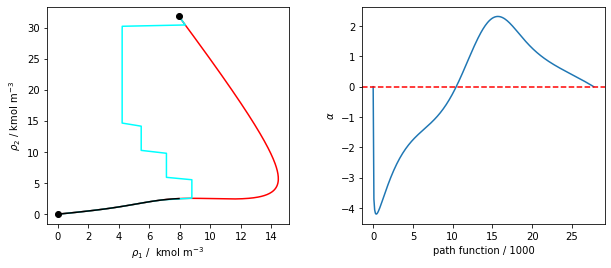

In [6]:
rhor1 = solr1.rho  / 1000  # kmol/m3
rhor2 = solr2.rho / 1000  # kmol/m3

rholiang =  soll.rho / 1000  # kmol/m3
alphas = soll.alphas
path = soll.path

fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(rhor1[0], rhor1[1], color = 'black')
ax1.plot(rhov[0]/1000, rhov[1]/1000, 'o', color = 'k')
ax1.plot(rhol[0]/1000, rhol[1]/1000, 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path/1000, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function / 1000')

## Hexane - Ethanol

The interfacial behavior of this mixture is well known to be difficult to study as its displays multiple stationary points in the inhomogeneous zone. 

In [7]:
hexane = component(GC={'CH3':2, 'CH2':4}, cii=3.288396028761707e-19)

mix2 = mixture(hexane, ethanol)
# or
mix2 = hexane + ethanol

mix2.saftgammamie()
eos2 = saftgammamie(mix2)

In this example, the bubble point of the mixture at $x_1=0.3$ and 298.15K is computed with the ```bubblePy``` function.

In [8]:
T = 298.15 # K
x = np.array([0.3, 0.7])
y0 = 1.*x
P0 = 8000. # Pa
sol = bubblePy(y0, P0, x, T, eos2, full_output=True)
y, P = sol.Y, sol.P
vl, vv = sol.v1, sol.v2
rhox = x/vl
rhoy = y/vv
sol

      T: 298.15
      P: 24565.962191556984
  error: 4.466405023606512e-11
   iter: 7
      X: array([0.3, 0.7])
     v1: 7.87121343627909e-05
  Xassl: array([0.07624009, 0.53812004])
 state1: 'Liquid'
      Y: array([0.72958876, 0.27041124])
     v2: 0.09980764886547946
  Xassv: array([0.99406146, 0.99703073])
 state2: 'Vapor'

Similar to the previous mixture, the ```sgt_mix_beta0``` is used to study the interfacial behavior of the mixture. 

In [9]:
solr1 = sgt_mix_beta0(rhoy, rhox, T, P, eos2, s=0, method='reference', full_output=True)
solr2 = sgt_mix_beta0(rhoy, rhox, T, P, eos2, s=1, method='reference', full_output=True)
soll = sgt_mix_beta0(rhoy, rhox, T, P, eos2, n=300, method='liang', full_output=True)

c:\users\gusta\documents\sgtpy\sgtpy\gammamie_mixtures\ahs_monomer.py:121: RuntimeWarning: invalid value encountered in log
  log3 = np.log(xhi3_1)
c:\users\gusta\documents\sgtpy\sgtpy\gammamie_mixtures\gdHS_chain.py:134: RuntimeWarning: invalid value encountered in log
  k0 = -np.log(xhix_1) + (42*xhix - 39*xhix2 + 9*xhix3 - 2*xhix4)/(6*xhix_13)
c:\users\gusta\documents\sgtpy\sgtpy\gammamie_mixtures\ares.py:926: RuntimeWarning: invalid value encountered in log
  aux1 = np.log(Xass) - Xass/2 + 1/2


The interfacial tension results are shown below.

In [10]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function: ', soll.tension, 'mN/m')

Reference component method (1) :  9.566628444206435 mN/m
Reference component method (2) :  17.00706982867569 mN/m
Liang path Function:  16.353369314683754 mN/m


As for the previous mixture, only the ```Liang``` path function method (red line) is able to compute the complete density path. 
The reference component method is not able to compute the complete density path using component 1 (black line) or component 2 (cyan line). This was expected because of the multiple stationary points on the density profile.
 
Additionally, the parametric variable $\alpha$ from the Liang path function is plotted. If this variable is different that zero at the equilibrium compositions, it is a sign that $\beta=0$ might not be suitable for the mixture.

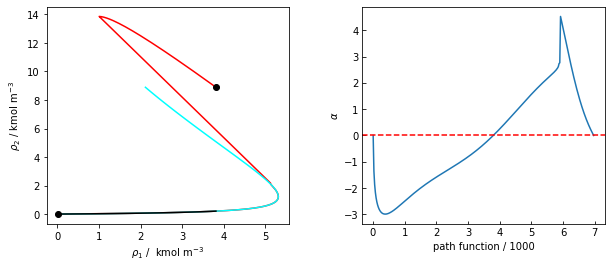

In [11]:
rhor1 = solr1.rho  / 1000  # kmol/m3
rhor2 = solr2.rho / 1000  # kmol/m3

rholiang =  soll.rho / 1000 # kmol/m3
alphas = soll.alphas
path = soll.path

fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(rhor1[0], rhor1[1], color = 'black')
ax1.plot(rhoy[0]/1000, rhoy[1]/1000, 'o', color = 'k')
ax1.plot(rhox[0]/1000, rhox[1]/1000, 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path/1000, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function / 1000')

ax2.tick_params(direction='in')
ax2.tick_params(direction='in')

# fig.savefig('sgt_mix_beta0.pdf')

For further information of any of these functions just run: ```function?```